# **<center>** DEEP LEARNING PROJECT - Parte 2
## **<center>** Giannelli Alessio , Imbonati Lorenzo , Valoti Davide

## Introduzione e Obiettivo

Il progetto in questa seconda parte mira all'implementazione di un modello che garantisce un'improvement significativo rispetto agli algoritmi precedentemente adddestrati. Si è quindi scelto di cambiare approccio: in primis passeremo al modello un input distinto da quello precedentemente creato, più precisamente useremo come input per la human activity recognition l'output che il modello Movenet ci fornisce; ins eocndo luogo non verranno coinvolti nell'architettura della rete neurale layers di convluzione ma cercheremo di cogliere le dipendenze temporali tra i vari frame esclusivamente con strati LSTM e relative tecniche affini.

## Importazione delle librerie necessarie
Si è deciso inoltre di salvare la sessione di modo da poter importare più velocemente i dati

In [ ]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm
import random

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Impostazione seed value
Necessario per garantire la riproducibilità dei risultati

In [ ]:
seed_value= 42

# OS seed
os.environ['PYTHONHASHSEED']=str(seed_value)

# python seed
random.seed(seed_value)

# numpy seed
np.random.seed(seed_value)

# tensorflow seed
tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Importazione del modello MoveNet lightning
La versione lightining è caratterizzata da una rapidità di esecuzione, richiesta vista la dimensione del dataset di input.

In [ ]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O model_lightning.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('model_lightning')

Cloning into 'examples'...
remote: Enumerating objects: 21837, done.
remote: Counting objects: 100% (497/497), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 21837 (delta 184), reused 377 (delta 114), pack-reused 21340
Receiving objects: 100% (21837/21837), 37.25 MiB | 16.32 MiB/s, done.
Resolving deltas: 100% (11945/11945), done.


## Definizione funzione per pose estimation tramite modello MoveNet
Data l'immagine di input, la funzione restituisce in output un oggetto MoveNet.SinglePose. Questo è ottenuto tramite l'applicazione della rete Movenet sull'immagine intera e successivamente sull'area che comprende il soggetto. Per migliorare l'affidabilità della stima, la ristima sulla sotto-area definita viene ripetuta per un numero di volte pari al parametro *inference_count*, di default pari a 3.

In [ ]:
def detect(input_tensor, inference_count=3):

  image_height, image_width, channel = input_tensor.shape

  # Identificazione del soggetto sull'intera immagine
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Identificazione ripetuta dei punti chiave del soggetto sulla sotto-area identificata
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [ ]:
## DEFINIZIONE PERCORSO AL DATASET E LISTA CON I NOMI DELLE CATEGORIE

# Directory ai dati
DATASET_DIR = "/content/drive/MyDrive/Codice e Dataset/gen_body"

# Lista con i nomi delle categorie
all_classes_names = os.listdir('/content/drive/MyDrive/Codice e Dataset/gen_body')
all_classes_names = os.listdir('/content/drive/MyDrive/Codice e Dataset/gen_body')
CLASSES_LIST = all_classes_names

Il passaggio successivo è quello di creare una funzione che permetta di estrarre i frames dai video, ridimensionarli con dimensione (240,380), essendo la più frequente nel dataset e salvarli solamente nel caso in cui la soglia *detection_threshold* venga superata per ogni punto chiave del soggetto in ciascuno dei frame del video relativo.

Si tratta di una funzione che presenta come unico argomento in input la directory al dataset con i video, e come output una lista che contiene i frames ridimensionati e normalizzati. Si sottolinea che la funzione appena citata verrà utilizzata all'interno della funzione successiva.

In [ ]:
detection_threshold=0.1

In [ ]:
def frames_extraction(video_path):
    # Si inizializza una lista vuota che conterrà i frames
    frames_list = []
    
    # Si riprende la funzione VideoCapture utilizzata precedentemente per "leggere" i video
    video_reader = cv2.VideoCapture(video_path)

    # A questo punto è necessario estrarre il numero totale di frame per video, questo perché 
    # si devono estrarre dei frame per tutta la lunghezza dei video e non solamente all'inizio
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # In questo modo infatti si suddivide il video in intervalli di frame uguali
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Si itera un ciclo for che andrà a scegliere 10 frames per video, li ridimensionerà e li normalizzerà singolarmente,
    # per poi aggiungerli alla lista inizializzata in precedenza
    for frame_counter in range(SEQUENCE_LENGTH):

        # In questo modo si selezionano in modo omogeneo i 10 frames sulla totalità del video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Si utilizza il comando per leggere i video
        # Si definisce inoltre anche l'elemento *success* perché l'elemento di lettura ha come output anche un valore booleano
        # che fornisce l'esito della procedura 
        success, frame = video_reader.read() 

        # Infatti in questo modo si verifica se la lettura è andata a buon fine
        if not success:
            return frames_list

        # Una volta estratti i frame, è necessario ridimensionarli con le dimensioni scelte 
        resized_frame = cv2.resize(frame, (240, 380))  
        
        # Conversione del frame in formato RGB e successivamente in tensore
        rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
        image = tf.convert_to_tensor(frame)

        # Identificazione dei punti chiave del soggetto tramite la funzione detect già definita
        person = detect(image)

        # Salvataggio dei 17 punti chiavi e verifica del superamento della soglia minimo per il punto con confidenza minima
        min_landmark_score = min(
            [keypoint.score for keypoint in person.keypoints])
        should_keep_image = min_landmark_score >= detection_threshold

        if not should_keep_image:
          return frames_list

        # Salvataggio di coordinate x e y e confidenza per ognuno dei punti chiave
        pose_landmarks = np.array(
            [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
              for keypoint in person.keypoints],
            dtype=np.float32)
        
        coordinates = pose_landmarks.flatten().astype(str).tolist()

        # Aggiunta del frame alla lista
        frames_list.append(coordinates)
    
    # Come detto in precedenza, dopo ogni lettura è necessario rilasciare l'elemento VideoCapture così che possa essere utilizzato su altri video 
    video_reader.release()

    # restituizione della lista di frame
    return frames_list

### **<font style="color:rgb(134,19,348)">Funzione per la Creazione del Dataset</font>**


Si implementa la funzione create_dataset() che iterarà entro tutte le classi specificate nella costante CLASSES_LIST e chiamerà la funzione frame_extraction() su ogni file video delle classi selezionate per infine restituire i frame (features), l'indice di classe (labels) e il percorso del file video (video_files_paths).

Per quanto riguarda questo approccio, è stato necessario escludere alcune classi dalle 19 individuate nella prima parte; questo perchè la Movenet necessita in input frames in cui la figura umana sia totalmente ripresa, difatti le classi che non abbiamo mantenuto in analisi risultano avere o nessun video congruo alle necessità o solo pochi video in cui il rispetto del vincolo appena descritto era garantito.

Si arriva ad ottenere quindi un dataset in cui le categorie della variabile target sono 12.

In [ ]:
def create_dataset():

    # Dichiaro le liste in cui effetturò lo storage di feature, labels e filepath
    features = []
    labels = []
    video_files_paths = []
    
    # Iterazione entro tutte le classi della variabile CLASSES_LIST
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        # Lista dei video nella specifica classe
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterazione nella lista dei file della classe
        for file_name in files_list:
            
            # Estraggo il video path
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Estraggo i frame di ogni video con la funzione creata in precedenza
            frames = frames_extraction(video_file_path)

            # Verifico che i frame estratti di ogni video corrispondano alla variabile SEQUENCE_LENGHT
            if len(frames) == SEQUENCE_LENGTH:

                # Aggiungo alle rispettive liste gli elementi estratti
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Restituisco i frame, le classi, e i filepath
    return features, labels, video_files_paths

In [ ]:
with tf.device('CPU:0'):
  features, labels, video_files_paths = create_dataset()

In [ ]:
with tf.device('GPU:0'):
  features = features*1
  labels = labels*1
  video_files_paths = video_files_paths*1

In [ ]:
features = np.asarray(features)
labels = np.array(labels)

#3. Divisione dei dati in Training e Validation Set

Una volta creato il dataset effettivo dal quale si potranno allenare i diversi modelli da utilizzare per la classificazione dei video con le proprie etichette, è necessario effettuare la suddivisione dei dati in Training e Validation Set. Essi rappresentano rispettivamente la porzione di dati per migliorare le prestazioni del modello e per valutare le performance su nuovi dati.

Si è deciso inoltre di inserire come parametri di suddivisione sia lo *shuffle*, che permette di ridurre il bias e lo *stratify*, che permette di mantenere la stessa ditribuzione delle categorie nei due nuovi set di dati. Si è infine mantenuto lo stesso seme definito in precedenza e si è decisa come dimensione del set di validazione una percentuale di circa il 25% del set di partenza.

In [ ]:
# Splitting del dataset in una partizione di Training ( 75% ) e in una di Testing ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant,
                                                                            stratify = labels)

In [ ]:
import collections
collections.Counter(labels_train)

Counter({0: 58,
         1: 31,
         2: 4,
         3: 13,
         4: 19,
         5: 10,
         6: 17,
         7: 4,
         8: 5,
         9: 17,
         10: 20,
         11: 12})

In [ ]:
collections.Counter(labels_test)

Counter({0: 20,
         1: 10,
         2: 1,
         3: 4,
         4: 7,
         5: 3,
         6: 6,
         7: 1,
         8: 2,
         9: 6,
         10: 7,
         11: 4})

In [ ]:
# Sfrutto keras per categorizzare la variabile target e trasformare il vettore delle labels in una matrice one_hot_encode
one_hot_encoded_labels = tf.keras.utils.to_categorical(labels)

In [ ]:
# Splitting del dataset in una partizione di Training ( 75% ) e in una di Testing ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant,
                                                                            stratify = labels)

In [ ]:
features_train = features_train.astype(float)
features_test = features_test.astype(float)

In [ ]:
inputs = keras.Input(shape=(SEQUENCE_LENGTH, 34)) ## coordinate
x = inputs
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Bidirectional(keras.layers.LSTM(256,activation = 'tanh', return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.LSTM(128,activation = 'tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(12, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Si crea un parametro di Early Stopping, stoppando l'algoritmo quando la loss sul validation non decresce dopo più di 15 epoche 
early_stopping_callback = EarlyStopping(monitor = 'loss', patience = 15, mode = 'min', restore_best_weights = True)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ["accuracy"])

model.summary()

LSTM_training_history = model.fit(x = features_train, y = labels_train, batch_size = 4, epochs=150, 
                                  shuffle = True, callbacks = [early_stopping_callback], validation_data = (features_test, labels_test))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 34)]          0         
                                                                 
 batch_normalization (BatchN  (None, 10, 34)           136       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 10, 512)          595968    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               328192    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0     

Il modello nella sua epoca migliore raggiunge ottimi risultati sul dataset di validation, l'accuracy ci mostra che la percentuale di corretta classsificazione delle osservazioni ammonta al 70%, mentre l'entropia ci mostra quanto la distribuzione del target previsto diverge da quella del target osservato: in questo caso il valore della categorical_crossentropy sembra prossimo alla convergenza, la quale verrebbe sicuramente raggiunta se si attuasse un processo di data enrichment.

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

3/3 [==============================] - 0s 7ms/step - loss: 1.5375 - accuracy: 0.7042


In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/Codice e Dataset/Consegna/Models/MoveNet_DEF.h5')

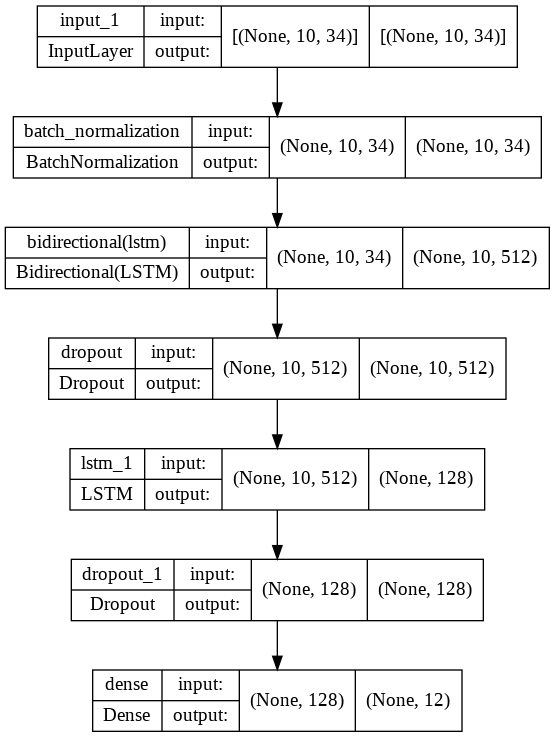

In [ ]:
tf.keras.utils.plot_model(model, to_file = 'MoveNet_model_structure_plot.png', show_shapes = True, show_layer_names = True)

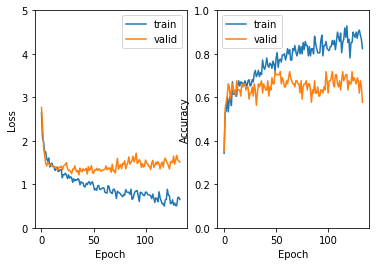

In [ ]:
## GRAFICI PER VISUALIZZARE L'ANDAMENTO DEL MODELLO

plt.subplot(1, 2, 1)
plt.plot(LSTM_training_history.history['loss'])
plt.plot(LSTM_training_history.history['val_loss'])
plt.ylim([0.0, 5.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(LSTM_training_history.history['accuracy'])
plt.plot(LSTM_training_history.history['val_accuracy'])
plt.ylim([0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])